In [19]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator

class SM(BaseEstimator):
    """Subspace Method (SM)
    Classification method using Subspace.
    
    Parameters
    ----------
    n_dimension : int
        Number of dimension of subspace.
    Attributes
    ----------
    subspaces_ : array, shape (n_classes, n_features, n_features)
        Subspace of N classes.
        
    classes_ : array, shape (n_classes,)
        Unique labels of Classes.
    """
    
    def __init__(self, n_dimension):
        self.n_dimension = n_dimension
    
    def fit(self, X, y):
        """Fit the model with X.
        X should be normalized because this method uses PCA.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples in the number of samples
            and n_features is the number of features.
        y : array_like, shape (n_samples,)
            Label data, where n_samples in the number of samples
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        self.classes_ = np.unique(y)
        self.subspaces_ = []
        for class_name in self.classes_:
            idx = np.argwhere(y == class_name).squeeze()
            X_class_i = X[idx, :]

            pca = PCA(n_components=self.n_dimension)
            pca.fit(X_class_i)

            # define projection matrix (equal to subspace)
            P = pca.components_.T @ pca.components_
            self.subspaces_.append(P)
            
        self.subspaces_ = np.array(self.subspaces_)
         
        return self

    def predict(self, X):
        """
        Perform classification on samples in X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Returns
        -------
        y_pred : array, shape (n_samples,)
            Class labels for samples in X.
        """

        #===<normal version>===#
#         n, d = X.shape
#         preds = []
#         for x in X:
#             similarities = []
#             for P in self.subspaces_:
#                 similarities.append(x.T @ P @ x)
#             preds.append(np.argmax(similarities))
#         return self.classes_[preds]

        #===<faster version (using broadcast)>===#
        # n: n_samples, d: n_features
        n, d = X.shape

        similarities = X.reshape((n, 1, 1, d)) @ \
            np.expand_dims(self.subspaces_, axis=0) @ \
            X.reshape((n, 1, d, 1))
        similarities = similarities.squeeze()
        
        return self.classes_[np.argmax(similarities, axis=1)]
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

    def get_params(self, deep=True):
        return {'n_dimension': self.n_dimension}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter, value)
        return self

# Prepare the data

In [3]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits_data = load_digits()
x = digits_data.data
y = digits_data.target

x -= np.mean(x, axis=0)

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.33, random_state=42)

In [4]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1203, 64) (1203,)
(594, 64) (594,)


# Training & Inference

In [20]:
sm = SM(n_dimension=10)
sm.fit(X_train, y_train)
y_pred = sm.predict(X_test)
sm.score(X_test, y_test)

0.80808080808080807

# Grid Search

In [91]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_dimension': [i for i in range(X_train.shape[1])]}
gs = GridSearchCV(sm, parameters, cv=5)
gs.fit(X_train, y_train)

gs.best_params_

{'n_dimension': 12}

In [26]:
sm = SM(**gs.best_params_)
sm.fit(X_train, y_train)
y_pred = sm.predict(X_test)
sm.score(X_test, y_test)

0.8232323232323232

# Validation Curve

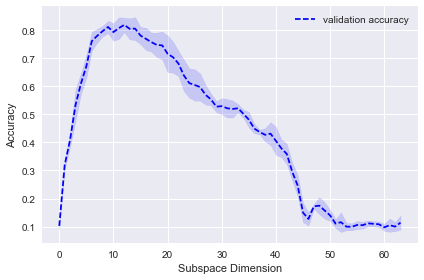

In [89]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.learning_curve import validation_curve

param_range = gs.get_params()['param_grid']['n_dimension']

test_mean = [gs.grid_scores_[i][1] for i in range(len(gs.get_params()['param_grid']['n_dimension']))]
test_std = np.std(
    [gs.grid_scores_[i][2] for i in range(len(gs.get_params()['param_grid']['n_dimension']))], 
    axis=1)

plt.plot(param_range, test_mean, 
         color='blue', linestyle='--', 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='blue')

plt.legend(loc='best')
plt.xlabel('Subspace Dimension')
plt.ylabel('Accuracy')
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

In [21]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.base import BaseEstimator

class KSM(BaseEstimator):
    """Subspace Method (SM)
    Classification method using Subspace.
    
    Parameters
    ----------
    n_dimension : int
        Number of dimension of subspace.
    Attributes
    ----------
    subspaces_ : array, shape (n_classes, n_features, n_features)
        Subspace of N classes.
        
    classes_ : array, shape (n_classes,)
        Unique labels of Classes.
    """
    
    def __init__(self, n_dimension, gamma):
        self.n_dimension = n_dimension
        self.gamma = gamma
    
    def fit(self, X, y):
        """Fit the model with X.
        X should be normalized because this method uses PCA.
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples in the number of samples
            and n_features is the number of features.
        y : array_like, shape (n_samples,)
            Label data, where n_samples in the number of samples
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        self.classes_ = np.unique(y)
        self.subspaces_ = []
        for class_name in self.classes_:
            idx = np.argwhere(y == class_name).squeeze()
            X_class_i = X[idx, :]

            pca = KernelPCA(n_components=self.n_dimension, kernel='rbf', gamma=self.gamma)
            pca.fit(X_class_i.T)

            # define projection matrix (equal to subspace)
            P = pca.alphas_ @ pca.alphas_.T
            self.subspaces_.append(P)
            
        self.subspaces_ = np.array(self.subspaces_)
         
        return self

    def predict(self, X):
        """
        Perform classification on samples in X.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Returns
        -------
        y_pred : array, shape (n_samples,)
            Class labels for samples in X.
        """

        #===<normal version>===#
#         n, d = X.shape
#         preds = []
#         for x in X:
#             similarities = []
#             for P in self.subspaces_:
#                 similarities.append(x.T @ P @ x)
#             preds.append(np.argmax(similarities))
#         return self.classes_[preds]

        #===<faster version (using broadcast)>===#
        # n: n_samples, d: n_features
        n, d = X.shape

        similarities = X.reshape((n, 1, 1, d)) @ \
            np.expand_dims(self.subspaces_, axis=0) @ \
            X.reshape((n, 1, d, 1))
        similarities = similarities.squeeze()
        
        return self.classes_[np.argmax(similarities, axis=1)]
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

    def get_params(self, deep=True):
        return {'n_dimension': self.n_dimension}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter, value)
        return self

In [33]:
sm = KSM(n_dimension=10, gamma=1e-4)
sm.fit(X_train, y_train)
y_pred = sm.predict(X_test)
sm.score(X_test, y_test)

0.97138047138047134